# Algoritmos de redes neuronales convolucionales

## Importamos las librerías necesarias

In [ ]:
pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import os.path
import time
import copy
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from patchify import patchify
from PIL import Image
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
import shutil
from sklearn.model_selection import StratifiedKFold
import zipfile
import matplotlib.pyplot as plt
import statistics
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import torch.nn.functional as F

## Obtenemos los datos de entrada

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocesamiento de las imágenes

In [ ]:
# Variables globales
magnification = "40X"
base_dataset = "drive/MyDrive/BreaKHis_v1/breast"
class_dir = ['benign', 'malignant']
sub_class_benign = ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma']
sub_class_malignant = ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']

In [ ]:
# Recorremos directorios para obtener las rutas de las imágenes
image_paths = []
for class_type in class_dir:
    if class_type == 'benign':
        for subclass in sub_class_benign:
            cur_dir = os.path.join(base_dataset, class_type, 'SOB', subclass)
            for folder in os.listdir(cur_dir):
                cur_dir2 = os.path.join(base_dataset, class_type, 'SOB', subclass, folder, magnification)
                for file in os.listdir(cur_dir2):
                    image_paths.append(os.path.join(cur_dir2, file))
    else:
        for subclass in sub_class_malignant:
            cur_dir = os.path.join(base_dataset, class_type, 'SOB', subclass)
            for folder in os.listdir(cur_dir):
                cur_dir2 = os.path.join(base_dataset, class_type, 'SOB', subclass, folder, magnification)
                for file in os.listdir(cur_dir2):
                    image_paths.append(os.path.join(cur_dir2, file))

In [ ]:
# Definimos array de imágenes y etiquetas
images = []
labels = []
for path in image_paths:
    if ".png" in path:
        image = cv2.imread(path, 1)
        images.append(image)
        labels.append(0) if "benign" in path else labels.append(1)


In [ ]:
np_images = np.array(images)
np_labels = np.array(labels)
np.save('images.npy', np_images)
np.save('labels.npy', np_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
# Calculamos el número de muestras con cáncer y sin cáncer
maligns = 0
benigns = 0
for l in range(len(labels)):
    if labels[l] == 1:
        maligns = maligns + 1 
    else:
        benigns = benigns + 1
print(maligns, benigns)

1370 625


##Funciones

In [ ]:
def images_to_patches(I_train, label_train, I_test, label_test):
  # Transformamos las imagenes de entrenamiento y prueba en patches de 224x224
  div = [[I_train, label_train],[I_test, label_test]]

  cnt = 0
  for X in div:
    cnt = cnt + 1
    patches_data = patchify(X[0][0], (224,224,3), step=112)
    patches = []
    p_labels = [] 
  
    for image in range(len(X[0])):
      for i in range(len(patches_data)):
          patches_data = patchify(X[0][image], (224,224,3), step=112)
          for j in range(len(patches_data[i])):
              for k in range(len(patches_data[i][j])):
                  patches.append(patches_data[i][j][k])
                  p_labels.append(X[1][image])

    if cnt == 1:
      X_train = patches
      y_train = p_labels
    else:
      X_test = patches
      y_test = p_labels

  return X_train, y_train, X_test, y_test

In [ ]:
def crear_directorio_patches(X_train, y_train, X_test, y_test, X_val, y_val, folder):
  # Creamos directorio para los patches 
  wd = '/content/'
  parts = ['train', 'val', 'test']
  classes = ['benign', 'malign']
  # Si los directorios ya existen se borran y se crean de nuevo vacíos
  if not os.path.exists(folder):
    os.mkdir(str(wd + folder))
  for p in parts:
    if os.path.exists(str(folder + '/' + p)):
      shutil.rmtree(str(folder + '/' + p))
    os.mkdir(str(wd + folder + '/' + p))
    for c in classes:
      os.mkdir(str(wd + folder + '/' + p + '/' + c))
  # En cada carpeta creada se guardan los patches correspondientes
  for p in parts:
      if p is 'train':
        X, y = X_train, y_train
      elif p is 'val':
        X, y = X_val, y_val
      else:
        X, y = X_test, y_test
      cnt = 0
      for im in X:
        data = Image.fromarray(im)
        if y[cnt] == 0:
          imagepath = str(wd + folder + '/' + p + '/' + classes[0] + '/imagen-' + str(cnt) + '.png')
          data.save(imagepath)
        else:
          imagepath = str(wd + folder + '/' + p + '/' + classes[1] + '/imagen-' + str(cnt) + '.png')
          data.save(imagepath)
        cnt = cnt + 1


In [ ]:
# Funcion de entrenamiento
def train_model(model, criterion, optimizer, scheduler, data_dir, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    best_acc_train = 0.0
    best_acc_val = 0.0
    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []

    data_transforms = {
      'train': transforms.Compose([
          transforms.ToTensor()
      ]),
      'val': transforms.Compose([
          transforms.ToTensor()
      ]),
    }
    
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2) for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    for phase in ['train', 'val']:
        print(phase, dataset_sizes[phase])

    # Early stopping
    last_loss = 100
    patience = 6
    trigger_times = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running = 0
            
            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


                #if running % 1000 == 0:
                #    print(running_loss, running_corrects)

            if phase == 'train':
              scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            if phase == 'train':
              loss_train.append(epoch_loss)
              acc_train.append(epoch_acc.cpu())
              if epoch_acc > best_acc_train:
                best_acc_train = epoch_acc

            if phase == 'val':
              loss_val.append(epoch_loss)
              acc_val.append(epoch_acc.cpu())
              if epoch_acc > best_acc_val:
                best_acc_val = epoch_acc
                
              # Early stopping
              if epoch_loss > last_loss and phase == 'val':
                trigger_times += 1
                print('Trigger Times:', trigger_times)

                if trigger_times >= patience:
                    print('Early stopping!')
                    time_elapsed = time.time() - since
                    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
                    print(f'Best train Acc: {best_acc_train:.4f} Best val Acc: {best_acc_val:.4f}')
                    return model
              else:
                  print('trigger times: 0')
                  trigger_times = 0

              last_loss = epoch_loss

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    range_epoch = range(num_epochs)

    plt.figure(figsize=(10, 7))
    plt.subplot(1, 2, 1)
    plt.plot(range_epoch, acc_train, label='Training Accuracy')
    plt.plot(range_epoch, acc_val, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Acc")

    plt.subplot(1, 2, 2)
    plt.plot(range_epoch, loss_train , label='Training Loss')
    plt.plot(range_epoch, loss_val, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best train Acc: {best_acc_train:.4f} Best val Acc: {best_acc_val:.4f}')

    return model 

In [ ]:
def probar_modelo(model, data_dir, phase, device):

  data_transforms = {
      'train': transforms.Compose([
          transforms.ToTensor()
      ]),
      'val': transforms.Compose([
          transforms.ToTensor()
      ]),
      'test': transforms.Compose([
          transforms.ToTensor()
      ])
    }
  image_dataset = datasets.ImageFolder(os.path.join(folder, phase), data_transforms[phase])
  dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=16, shuffle=True, num_workers=2)
  dataset_size = len(image_dataset)
  print(phase,dataset_size)
  model.eval()

  running_accuracy = 0 
  running_loss = 0
  total = 0 
  y_true = []
  y_pred = []

  with torch.no_grad(): 
        for inputs, outputs in dataloader: 
            inputs, outputs = inputs.to(device), outputs.to(device)
            predicted_outputs = model(inputs) 
            #print("input")
            #print(inputs)
            _, predicted = torch.max(predicted_outputs, 1) 
            loss = criterion(predicted_outputs, outputs)
            total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum()
            running_loss += loss.item() * inputs.size(0)

            for l in np.array(predicted.cpu()):
              y_pred.append(l)
            for l in np.array(outputs.data.cpu()):
              y_true.append(l)

            #print(predicted.cpu())
            #print(type(np.array(predicted.cpu())))
            #print(outputs.data.cpu())
            #print(type(outputs.data.cpu()))
            #print(outputs)
            #print("pred")
            #print(predicted)
            #if total % 1000 == 0:
            #        print(total, running_accuracy)

        test_loss = running_loss / dataset_size
        c_matrix = confusion_matrix(y_true, y_pred)
        acc = 100 * running_accuracy / total
        print(phase, 'accuracy:', acc, ', Loss:', test_loss)
        return acc, c_matrix

              


## Implementación

In [ ]:
######codigo solo para crear los directorios#######
# Definimos parámetros de validación cruzada
kf = StratifiedKFold(n_splits=5)


#### IMPLEMENTACION ####
test_indexes = []
test_acc_results = []
cnt = 0
for train_index, test_index in kf.split(images, labels):
  cnt = cnt + 1
  print("Ejecutando " + str(cnt) + "-fold...")
  test_indexes.append(test_index)

  images = np.array(images)
  labels = np.array(labels)
  X_im_train, X_im_test = images[train_index], images[test_index]
  y_im_train, y_im_test = labels[train_index], labels[test_index]

  # Transformación de imágenes de entrenamiento y prueba en patches
  X_train, y_train, X_test, y_test = images_to_patches(X_im_train, y_im_train, X_im_test, y_im_test)

  # Dividimos conjunto de entrenamiento en entrenamiento y validación
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
  print("División en entrenamiento, prueba y validación completado")

  # Guardamos los patches
  folder = "patches_data_" + str(cnt) + "-fold"
  crear_directorio_patches(X_train, y_train, X_test, y_test, X_val, y_val, folder)
  print("Directorio para " + str(cnt) + "-fold creado")

Ejecutando 1-fold...
[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 625, 626, 627, 628, 629,
       630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642,
       643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655,
       656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668,
       669, 670, 671, 672, 673, 674, 675, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


División en entrenamiento, prueba y validación completado
Directorio para 1-fold creado
Ejecutando 2-fold...
[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 625, 626, 627, 628, 629,
       630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642,
       643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655,
       656, 657, 658, 659,

In [ ]:
# Guardamos las imágenes de test de la última iteración para después probar el modelo
for i in test_indexes[3]:
  im = images[i]
  data = Image.fromarray(im)
  imagepath = str('/content/drive/MyDrive/data/imagenes-test/im-' + str(i) + '.png')
  data.save(imagepath)

In [ ]:
archivo_zip = shutil.make_archive("patches_data_1-fold-new", 
                                  "zip", 
                                  base_dir ="/content/patches_data_1-fold")

 
file_source = '/content/patches_data_1-fold-new.zip'
file_destination = '/content/drive/MyDrive/data'
 
shutil.move(file_source, file_destination)

archivo_zip = shutil.make_archive("patches_data_2-fold-new", 
                                  "zip", 
                                  base_dir ="/content/patches_data_2-fold")

 
file_source = '/content/patches_data_2-fold-new.zip'
file_destination = '/content/drive/MyDrive/data'
 
shutil.move(file_source, file_destination)

archivo_zip = shutil.make_archive("patches_data_3-fold-new", 
                                  "zip", 
                                  base_dir ="/content/patches_data_3-fold")

 
file_source = '/content/patches_data_3-fold-new.zip'
file_destination = '/content/drive/MyDrive/data'
 
shutil.move(file_source, file_destination)

archivo_zip = shutil.make_archive("patches_data_4-fold-new", 
                                  "zip", 
                                  base_dir ="/content/patches_data_4-fold")

 
file_source = '/content/patches_data_4-fold-new.zip'
file_destination = '/content/drive/MyDrive/data'
 
shutil.move(file_source, file_destination)

'/content/drive/MyDrive/data/patches_data_4-fold-new.zip'

train 17955
val 5985
Epoch 0/19
----------
train Loss: 0.4299 Acc: 0.8264
trigger times: 0
val Loss: 1.0551 Acc: 0.6506
Epoch 1/19
----------
train Loss: 0.2692 Acc: 0.8853
Trigger Times: 1
val Loss: 1.3471 Acc: 0.6847
Epoch 2/19
----------
train Loss: 0.2179 Acc: 0.9092
Trigger Times: 2
val Loss: 1.6806 Acc: 0.7514
Epoch 3/19
----------
train Loss: 0.1823 Acc: 0.9261
trigger times: 0
val Loss: 0.9967 Acc: 0.7895
Epoch 4/19
----------
train Loss: 0.1642 Acc: 0.9346
trigger times: 0
val Loss: 0.3561 Acc: 0.8391
Epoch 5/19
----------
train Loss: 0.1365 Acc: 0.9455
trigger times: 0
val Loss: 0.2521 Acc: 0.9033
Epoch 6/19
----------
train Loss: 0.1178 Acc: 0.9544
Trigger Times: 1
val Loss: 0.3057 Acc: 0.8809
Epoch 7/19
----------
train Loss: 0.0700 Acc: 0.9764
trigger times: 0
val Loss: 0.0524 Acc: 0.9805
Epoch 8/19
----------
train Loss: 0.0568 Acc: 0.9805
Trigger Times: 1
val Loss: 0.0571 Acc: 0.9788
Epoch 9/19
----------
train Loss: 0.0505 Acc: 0.9838
Trigger Times: 2
val Loss: 0.0853 A

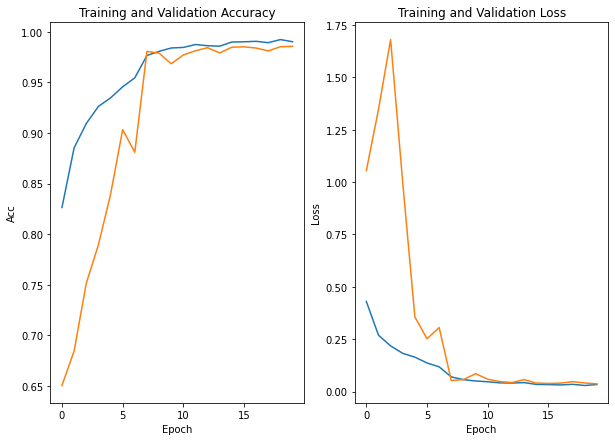

Training complete in 25m 16s
Best train Acc: 0.9921 Best val Acc: 0.9855
train 17955
train accuracy: tensor(99.8218, device='cuda:0') , Loss: 0.011044589299433695
val 5985
val accuracy: tensor(98.5464, device='cuda:0') , Loss: 0.03666128086592816
test 5985
test accuracy: tensor(71.5121, device='cuda:0') , Loss: 1.5471866981103806
... 1-fold terminado ...
train 17955
val 5985
Epoch 0/19
----------
train Loss: 0.4541 Acc: 0.8168
trigger times: 0
val Loss: 2.0013 Acc: 0.6919
Epoch 1/19
----------
train Loss: 0.3157 Acc: 0.8653
trigger times: 0
val Loss: 1.6498 Acc: 0.7114
Epoch 2/19
----------
train Loss: 0.2397 Acc: 0.9010
trigger times: 0
val Loss: 1.5579 Acc: 0.4921
Epoch 3/19
----------
train Loss: 0.2107 Acc: 0.9143
Trigger Times: 1
val Loss: 1.9492 Acc: 0.5265
Epoch 4/19
----------
train Loss: 0.1836 Acc: 0.9241
trigger times: 0
val Loss: 0.1909 Acc: 0.9283
Epoch 5/19
----------
train Loss: 0.1601 Acc: 0.9357
Trigger Times: 1
val Loss: 0.4137 Acc: 0.8204
Epoch 6/19
----------
train 

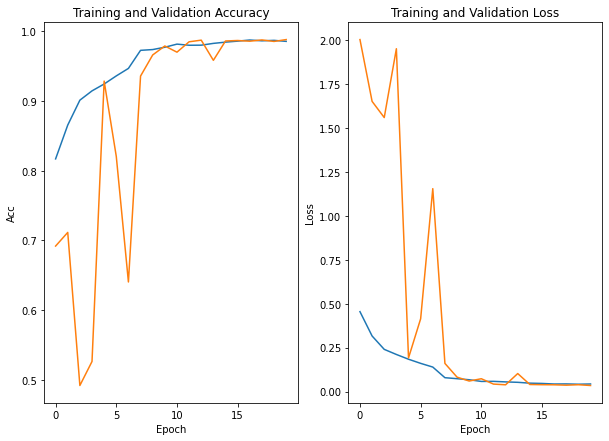

Training complete in 26m 6s
Best train Acc: 0.9872 Best val Acc: 0.9878
train 17955
train accuracy: tensor(99.7271, device='cuda:0') , Loss: 0.014202183711929162
val 5985
val accuracy: tensor(98.7803, device='cuda:0') , Loss: 0.034187251643441115
test 5985
test accuracy: tensor(90.3926, device='cuda:0') , Loss: 0.5333026305446192
... 2-fold terminado ...
train 17955
val 5985
Epoch 0/19
----------
train Loss: 0.4713 Acc: 0.8017
trigger times: 0
val Loss: 0.9776 Acc: 0.6391
Epoch 1/19
----------
train Loss: 0.3196 Acc: 0.8612
trigger times: 0
val Loss: 0.2942 Acc: 0.8799
Epoch 2/19
----------
train Loss: 0.2586 Acc: 0.8881
Trigger Times: 1
val Loss: 1.0087 Acc: 0.7830
Epoch 3/19
----------
train Loss: 0.2288 Acc: 0.9030
trigger times: 0
val Loss: 0.5534 Acc: 0.7751
Epoch 4/19
----------
train Loss: 0.1926 Acc: 0.9212
trigger times: 0
val Loss: 0.4552 Acc: 0.8069
Epoch 5/19
----------
train Loss: 0.1747 Acc: 0.9287
Trigger Times: 1
val Loss: 0.7587 Acc: 0.7773
Epoch 6/19
----------
train 

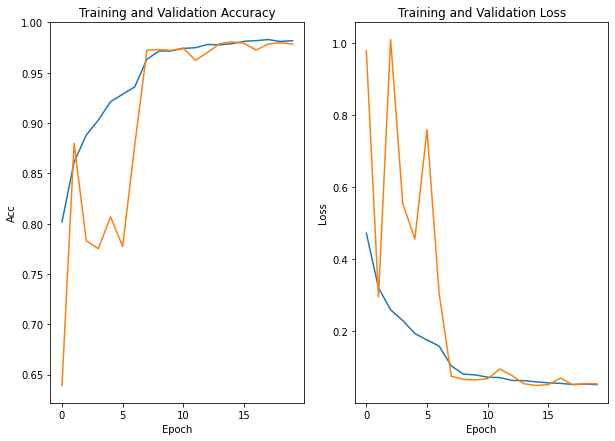

Training complete in 26m 10s
Best train Acc: 0.9830 Best val Acc: 0.9808
train 17955
train accuracy: tensor(99.4486, device='cuda:0') , Loss: 0.022902688145182214
val 5985
val accuracy: tensor(97.8613, device='cuda:0') , Loss: 0.05320532503277188
test 5985
test accuracy: tensor(90.4762, device='cuda:0') , Loss: 0.24180780504655122
... 3-fold terminado ...
train 17955
val 5985
Epoch 0/19
----------
train Loss: 0.4522 Acc: 0.8096
trigger times: 0
val Loss: 0.9528 Acc: 0.7581
Epoch 1/19
----------
train Loss: 0.2982 Acc: 0.8711
trigger times: 0
val Loss: 0.5317 Acc: 0.7589
Epoch 2/19
----------
train Loss: 0.2380 Acc: 0.9010
trigger times: 0
val Loss: 0.3310 Acc: 0.8454
Epoch 3/19
----------
train Loss: 0.1967 Acc: 0.9192
trigger times: 0
val Loss: 0.2874 Acc: 0.8692
Epoch 4/19
----------
train Loss: 0.1672 Acc: 0.9337
Trigger Times: 1
val Loss: 0.3742 Acc: 0.8675
Epoch 5/19
----------
train Loss: 0.1453 Acc: 0.9417
Trigger Times: 2
val Loss: 0.4145 Acc: 0.8252
Epoch 6/19
----------
train

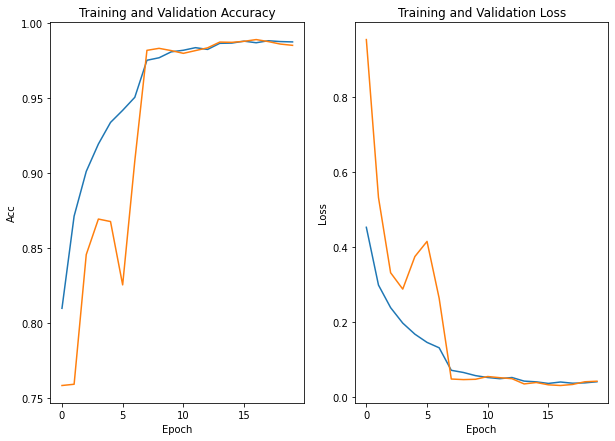

Training complete in 26m 0s
Best train Acc: 0.9882 Best val Acc: 0.9890
train 17955
train accuracy: tensor(99.4041, device='cuda:0') , Loss: 0.02055864806120083
val 5985
val accuracy: tensor(98.5129, device='cuda:0') , Loss: 0.041751269796796484
test 5985
test accuracy: tensor(88.5547, device='cuda:0') , Loss: 0.554774724909765
... 4-fold terminado ...


In [ ]:
### Implementación para ejecutar el entrenamiento con los patches ya creados
# Definimos parámetros de validación cruzada
kf = StratifiedKFold(n_splits=4)


#### IMPLEMENTACION ####

test_acc_results = []
c_matrix_list = []
cnt = 0
for i in range(1,5):
  cnt = cnt + 1
  folder_zip = "/content/drive/MyDrive/data/patches_data_" + str(cnt) + "-fold-new.zip"
  shutil.unpack_archive(folder_zip, "/")

  folder = "/content/patches_data_" + str(cnt) + "-fold"

  # Inicializamos el modelo
  model = models.resnet18()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = model.to(device)

  # Definimos criterio
  criterion = nn.CrossEntropyLoss()

  # Definimos el optimizador
  optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  # Definimos la tasa de aprendizaje
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  # Entrenamiento y validación
  model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, folder, num_epochs=20)

  # Prueba
  acc_train, cm_train = probar_modelo(model_ft, folder, 'train', device)
  acc_val, cm_val = probar_modelo(model_ft, folder, 'val', device)
  acc_test, cm_test = probar_modelo(model_ft, folder, 'test', device)
  
  test_acc_results.append(acc_test)
  c_matrix_list.append(cm_test)

  print("... " + str(cnt) + "-fold terminado ...")

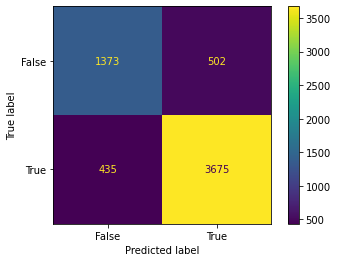

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
model_path = "/content/drive/MyDrive/data/resnet20epoch0.001LR-state_dict-new.pth"

torch.save(model_ft.state_dict(), model_path)
